# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/roni/.virtualenvs/metnum-tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/roni/Documents/metnum/metnum-tp2
-- Configuring done
-- G

In [2]:
import dill
df_folds_file = open("data/df_folds", "rb")
try:
    data = df_folds_file.read()
    df_folds = dill.loads(data)
finally:
    df_folds_file.close()

In [29]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum
from commons import *


/home/roni/Documents/metnum/metnum-tp2/notebooks
Python 3.8.5


## Explorando los datos

In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Es un csv, con columnas por cada pixel

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [43]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [44]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 3


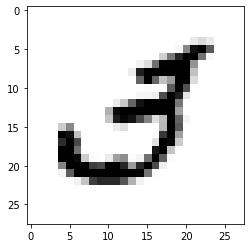

In [45]:
import matplotlib.pyplot as plt

num = 417

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [46]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [47]:
import random
from functools import reduce

def split_in_folds(X,y,K_folds):
    limit = X.shape[0]
    order = list(range(0,limit))
    random.shuffle(order)

    X_shuffled, y_shuffled = [], [] 

    for i in order:
        X_shuffled += [X[i]]
        y_shuffled += [y[i]]

    folds_size = int(limit/K_folds)

    X_folds, y_folds = [], []

    for i in range(0,K_folds):
        l, h = i * folds_size , (i+1) * folds_size
        X_folds += [X_shuffled[l:h]]
        y_folds += [y_shuffled[l:h]]
    return (X_folds,y_folds)
    
def getKFold(X_folds,y_folds, K):
    X_train_folds = X_folds[0:K] + X_folds[K+1:len(X_folds)]
    y_train_folds = y_folds[0:K] + y_folds[K+1:len(y_folds)]
    train = (reduce(lambda a,b : a+b,X_train_folds), reduce(lambda a,b : a+b,y_train_folds))
    val = (X_folds[K], y_folds[K])
    return (train,val)


In [48]:
from datetime import datetime, timedelta
from tqdm import tqdm

In [49]:
folds = range(3,11)
runs = 5

In [50]:
%%time
from sklearn.metrics import accuracy_score

df_folds = pd.DataFrame(columns = ["k-fold", "fold", "accuracy", "precision", "recall", "cohens-kappa", "f1-score", "times", "runs"])
for K_folds in tqdm(folds):
    X_folds, y_folds = split_in_folds(X,y,K_folds)    
    for f in range(K_folds):
        for r in range(runs):
            test_train, test_val = getKFold(X_folds,y_folds,f)
            start = datetime.now()
            accuracy, precision, recall, cohen, f1 = pca_knn_accuracy(20, 5, test_train, test_val)
            time = (datetime.now() - start)
            dicc = {"k-fold": K_folds, "fold": f, "accuracy": accuracy, "precision": precision, "recall": recall, "cohens-kappa": cohen, "f1-score": f1, "times": time.microseconds, "runs": r}
            df_folds = df_folds.append(dicc, ignore_index=True)

df_folds_file = open("data/df_folds", "wb")
try:
    data = dill.dumps(df_folds)
    df_folds_file.write(data)
finally:
    df_folds_file.close()
          
df_folds.groupby("k-fold").mean()

100%|██████████| 8/8 [03:50<00:00, 28.86s/it]

CPU times: user 3min 50s, sys: 330 ms, total: 3min 50s
Wall time: 3min 50s


,fold,accuracy,precision,recall,cohens-kappa,f1-score,times,runs
k-fold,,,,,,,,
3.0,1.0,0.930972,0.929960,0.929690,0.923239,0.929824,905010.533333,2.0
4.0,1.5,0.933400,0.932697,0.932193,0.925929,0.932445,961016.300000,2.0
5.0,2.0,0.938600,0.938398,0.937857,0.931713,0.938127,922091.680000,2.0
6.0,2.5,0.937575,0.936608,0.936762,0.930556,0.936685,889008.200000,2.0
7.0,3.0,0.939376,0.938347,0.938626,0.932532,0.938486,898659.457143,2.0
8.0,3.5,0.937400,0.936769,0.935682,0.930315,0.936225,870787.550000,2.0
9.0,4.0,0.937938,0.936650,0.935740,0.930877,0.936194,841704.133333,2.0
10.0,4.5,0.940000,0.940074,0.939179,0.933218,0.939625,837194.740000,2.0


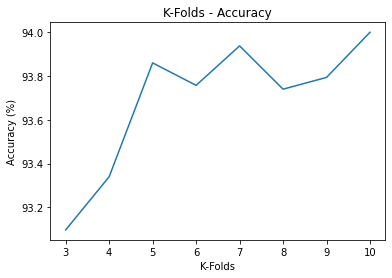

In [63]:
# Plot KNN - Accuracy x K
import matplotlib.pyplot as plt
grouped_df_folds = df_folds.groupby("k-fold").mean()

plt.plot(folds, grouped_df_folds["accuracy"]*100)
plt.title('K-Folds - Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('K-Folds')
plt.show()

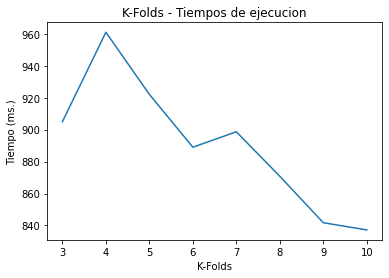

In [64]:
# Plot KNN - Precision + Recall x Kc
plt.plot(folds, grouped_df_folds["times"]/1000)
plt.title('K-Folds - Tiempos de ejecucion')
plt.ylabel('Tiempo (ms.)')
plt.xlabel('K-Folds')
plt.show()

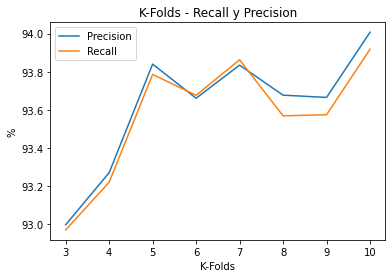

In [65]:
# Plot KNN - Precision + Recall x Kc
plt.plot(folds, grouped_df_folds["precision"]*100, label="Precision")
plt.plot(folds, grouped_df_folds["recall"]*100, label="Recall")
plt.title('K-Folds - Recall y Precision')
plt.legend()
plt.ylabel('%')
plt.xlabel('K-Folds')
plt.show()

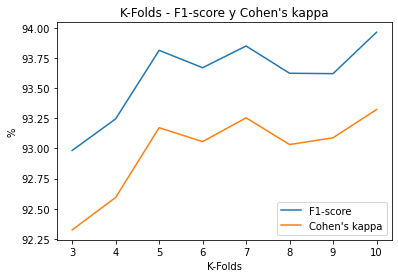

In [66]:
# Plot KNN - F1 score + Cohen's Kappa x K
plt.plot(folds, grouped_df_folds["f1-score"]*100, label="F1-score")
plt.plot(folds, grouped_df_folds["cohens-kappa"]*100, label="Cohen's kappa")
plt.title('K-Folds - F1-score y Cohen\'s kappa')
plt.legend()
plt.ylabel('%')
plt.xlabel('K-Folds')
plt.show()

In [62]:
df_folds.groupby(["k-fold","fold"]).mean()

accuracy  precision    recall  cohens-kappa  f1-score     times  \
k-fold fold                                                                    
3.0    0.0   0.928571   0.927617  0.925599      0.920538  0.926607  952952.4   
       1.0   0.933974   0.932788  0.933617      0.926596  0.933202  959189.6   
       2.0   0.930372   0.929475  0.929853      0.922583  0.929664  802889.6   
4.0    0.0   0.931200   0.928829  0.927749      0.923460  0.928289  948066.6   
       1.0   0.936800   0.936223  0.937279      0.929755  0.936750  976016.4   
       2.0   0.930400   0.929840  0.928667      0.922566  0.929253  972603.6   
       3.0   0.935200   0.935895  0.935077      0.927936  0.935486  947378.6   
5.0    0.0   0.949000   0.949659  0.947816      0.943271  0.948736  917463.4   
       1.0   0.923000   0.922175  0.922617      0.914386  0.922396  916971.8   
       2.0   0.944000   0.942949  0.942141      0.937724  0.942545  922522.6   
       3.0   0.939000   0.939869  0.937671      0.932102  0.938769  935074.6   
       4.0   0.938000   0.937338  0.939043      0.931081  0.938190  918426.0   
6.0    0.0   0.935174   0.934264  0.935031      0.927926  0.934647  921517.2   
       1.0   0.930372   0.929678  0.930233      0.922540  0.929955  734209.4   
       2.0   0.935174   0.935032  0.934270      0.927911  0.934651  948193.8   
       3.0   0.944778   0.943595  0.944423      0.938567  0.944009  895014.8   
       4.0   0.945978   0.943788  0.943651      0.939885  0.943719  932245.2   
       5.0   0.933974   0.933291  0.932967      0.926508  0.933129  902868.8   
7.0    0.0   0.943978   0.942573  0.942956      0.937696  0.942764  914781.4   
       1.0   0.935574   0.935450  0.934545      0.928370  0.934997  885464.6   
       2.0   0.950980   0.950044  0.951750      0.945435  0.950896  893347.8   
       3.0   0.939776   0.938127  0.941345      0.932970  0.939733  910432.2   
       4.0   0.922969   0.922999  0.922779      0.914298  0.922889  899644.2   
       5.0   0.934174   0.931766  0.931121      0.926713  0.931444  896063.0   
       6.0   0.948179   0.947469  0.945886      0.942241  0.946677  890883.0   
8.0    0.0   0.936000   0.934266  0.935779      0.928724  0.935022  859315.2   
       1.0   0.945600   0.944999  0.942042      0.939419  0.943518  879221.6   
       2.0   0.932800   0.932995  0.932787      0.925273  0.932891  892173.6   
       3.0   0.940800   0.939134  0.936648      0.934099  0.937889  847791.2   
       4.0   0.924800   0.926057  0.925717      0.916415  0.925887  870291.8   
       5.0   0.936000   0.933226  0.931509      0.928686  0.932366  869870.6   
       6.0   0.940800   0.942288  0.940220      0.933989  0.941253  891310.6   
       7.0   0.942400   0.941185  0.940755      0.935913  0.940970  856325.8   
9.0    0.0   0.938739   0.939243  0.934579      0.931749  0.936906  853657.8   
       1.0   0.929730   0.927921  0.927905      0.921834  0.927913  865761.2   
       2.0   0.935135   0.934399  0.934270      0.927584  0.934334  845495.4   
       3.0   0.945946   0.943308  0.942150      0.939811  0.942729  845257.4   
       4.0   0.951351   0.950618  0.950336      0.945861  0.950477  815377.6   
       5.0   0.933333   0.929230  0.927738      0.925764  0.928483  831692.0   
       6.0   0.947748   0.947324  0.948825      0.941827  0.948074  838270.2   
       7.0   0.922523   0.923719  0.923494      0.913793  0.923606  825210.4   
       8.0   0.936937   0.934088  0.932362      0.929670  0.933224  854615.2   
10.0   0.0   0.946000   0.943646  0.945057      0.939942  0.944351  857821.4   
       1.0   0.958000   0.956406  0.957443      0.953232  0.956924  834851.8   
       2.0   0.944000   0.943959  0.941622      0.937650  0.942789  827070.6   
       3.0   0.932000   0.932783  0.931222      0.924320  0.932002  826690.0   
       4.0   0.936000   0.937822  0.936485      0.928770  0.937153  854132.6   
       5.0   0.926000   0.926395  0.926940      0.917646  0.926667  856607.0   
       6.0   

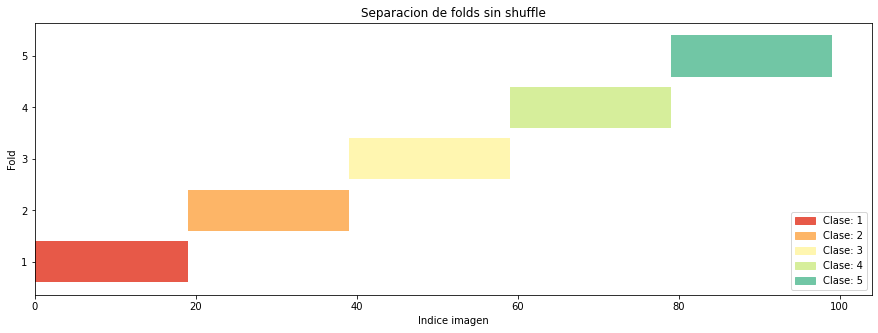

In [241]:
images = 100
clases = 5
img_per_class = int(images/clases)
dataset = []
for i in range(clases):
    dataset += [i]*img_per_class

colors = [plt.get_cmap('Spectral')(int((i+1)*40)) for i in range(clases)]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

for i in range(images-1,-1,-1):
    v = int(i/(images/5))+1 
    ax.barh(v,i,color=colors[dataset[i]]) 
    
for i in range(2,6): 
    ax.barh(i,images/5*(i-1)-1,color='white')

import matplotlib.patches as mpatches
legends = [mpatches.Patch(color=colors[i], label=f'Clase: {i+1}') for i in range(clases)]
plt.legend(handles=legends, loc='lower right')
plt.title("Separacion de folds sin shuffle")
plt.xlabel("Indice imagen")
plt.ylabel("Fold")

plt.show()

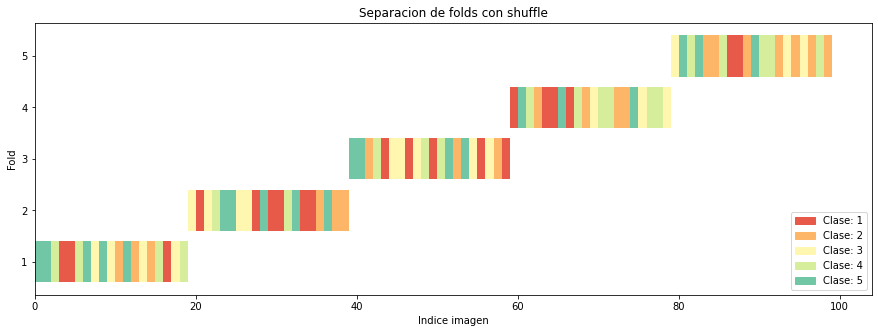

In [242]:
dataset_random = dataset.copy()
random.shuffle(dataset_random)

colors = [plt.get_cmap('Spectral')(int((i+1)*(40))) for i in range(clases)]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

for i in range(images-1,-1,-1):
    v = int(i/(images/5))+1 
    ax.barh(v,i,color=colors[dataset_random[i]]) 
    
for i in range(2,6): 
    ax.barh(i,images/5*(i-1)-1,color='white')

import matplotlib.patches as mpatches
legends = [mpatches.Patch(color=colors[i], label=f'Clase: {i+1}') for i in range(clases)]
plt.legend(handles=legends, loc='lower right')
plt.title("Separacion de folds con shuffle")
plt.xlabel("Indice imagen")
plt.ylabel("Fold")

plt.show()

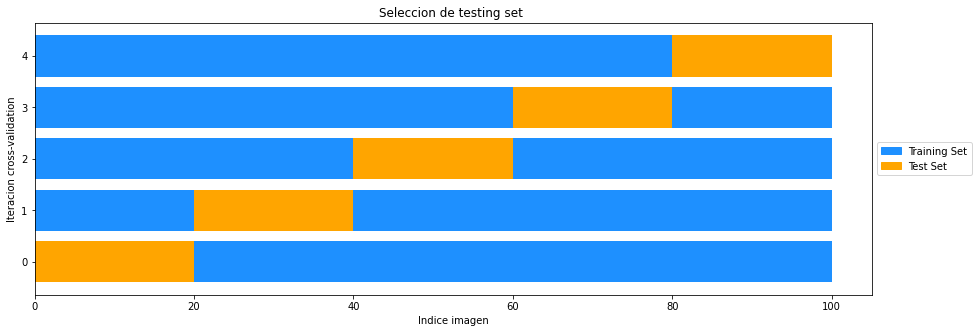

In [222]:
images = 100
indexes_folds = split_in_folds_indexes(X[:images],y[:images],5,False)
indexes_vals = []
indexes = reduce(lambda a,b : a+b,indexes_folds)
for i in indexes:
    indexes_vals.append(y[i][0])

    
colors = [plt.get_cmap('Spectral')(int((i+1)*(25))) for i in range(10)]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

for i in range(5):
    l = i*images/5
    m = (i+1)*images/5
    h = images
    
    ax.barh(i,h,color="dodgerblue")
    ax.barh(i,m,color="orange")  
    ax.barh(i,l,color="dodgerblue") 
    

import matplotlib.patches as mpatches
traing_patch = mpatches.Patch(color="dodgerblue", label="Training Set")
testing_patch = mpatches.Patch(color="orange", label="Test Set")
legends = [traing_patch,testing_patch]
plt.legend(handles=legends, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Seleccion de testing set ")
plt.xlabel("Indice imagen")
plt.ylabel("Iteracion cross-validation")

plt.show()